# Bayesian linear regression

Linear regression parameters are often determined as those that minimize the squared error. What happens if we treat the parameters as a probability distribution?

Forst, as usual, we import stuff.

In [0]:
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

As test data, Anscombe's quartet is a handy choice.

In [0]:
def anscombe(n=1):
  assert 1 <= n and n <= 4
  X = np.vstack([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
  if n == 1:
    y = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
  elif n == 2:
    y = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
  elif n == 2:
    y = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
  elif n == 2:
    X = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
    y = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]
  X = np.vstack(X)
  y = np.asarray(y)
  return X, y

X, y = anscombe(1)

This is the model $\hat y = \theta_0 + \sum_{i=1}^n \theta_1 x_i$.

In [0]:
def y_hat(x, theta):
  ret = theta[0] + x*theta[1]
  return ret.ravel()

We know that the parameter vector for Anscombe's quartet is $\theta = (3, .5)^\top$. That gives this line.

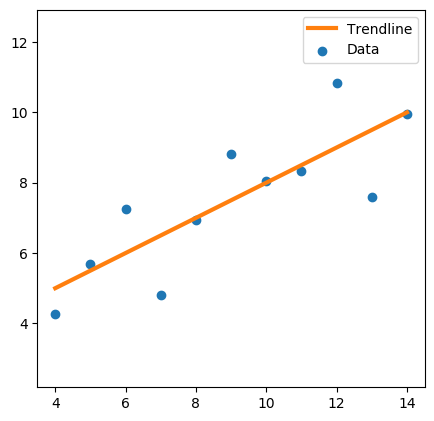

In [4]:
theta = np.asarray([3, .5])

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(X, y, color='C0', label="Data")
x_plot = np.linspace(X.min(), X.max(), 10)
plt.plot(x_plot, y_hat(x_plot, theta), color='C1', linewidth=3, label="Trendline")
plt.axis('equal')
plt.legend()
plt.show()

$P(\theta \mid \mathfrak{D}) \propto P(\mathfrak{D} \mid \theta) P(\theta)$

$f(x_{1},\ldots ,x_{n}\mid \mu ,\sigma ^{2})=\prod _{i=1}^{n}f(x_{i}\mid \mu ,\sigma ^{2})=\left({\frac {1}{2\pi \sigma ^{2}}}\right)^{n/2}\exp \left(-{\frac {\sum _{i=1}^{n}(x_{i}-\mu )^{2}}{2\sigma ^{2}}}\right)$

In [5]:
from scipy.stats import norm

P = lambda theta: np.exp( -len(y)/2*np.log(2*np.pi*theta[2]**2) - (1/(2*theta[2]**2))*np.sum((y - y_hat(X, theta[:2]))**2) + -.5*np.sum(theta**2/10**2) )*np.sign(theta[2])

theta = np.asarray([3, .5, 1])
P(theta)

3.9739353617122046e-08

In [0]:
xx, yy = np.meshgrid(np.arange(-1, 6, .01), # beta0
                      np.arange(.1, 1.5, .01)) # beta1
grid_coordinates = np.c_[xx.ravel(), yy.ravel(), np.ones((len(xx.ravel()), 1))*5]

Z = np.apply_along_axis(P, 1, grid_coordinates)
Z = Z.reshape(xx.shape)

Left: P with a fixed variance 

Right: P with fixed $\theta_{0, 1}$ ($\beta_0$, $\beta_1$)

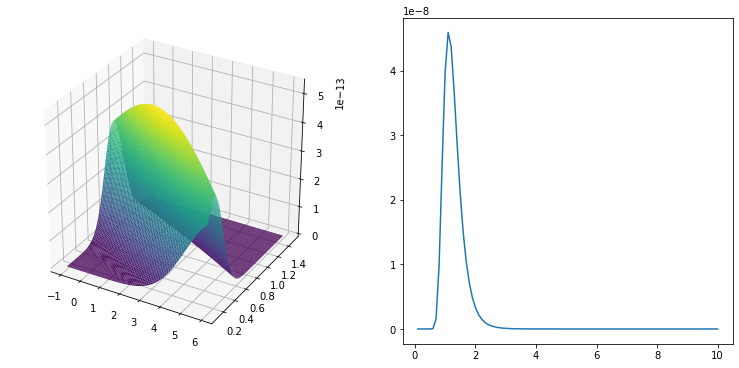

In [7]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(xx, yy, Z, rstride=1, cstride=10, cmap='viridis')
ax = fig.add_subplot(1, 2, 2)
sigma = np.linspace(.1, 10, 100)
p = [P(np.asarray([3, .5, s])) for s in sigma]
plt.plot(sigma, p)
plt.show()

For estimating the distribution of parameters, we can run Metropolis-Hastings sampling.

In [0]:
def metropolis_hastings(func, x0, n_iter=1000, scale=0.2):
  samples = np.zeros((n_iter, len(x0)))
  accepted = np.zeros(n_iter)
  x = np.asarray(x0)
  for iteration in tqdm(range(n_iter), desc="Running Metropolis-Hastings sampling"):
    x_star = x + np.random.normal(scale=scale, size=len(x0))
    if x_star[2] < .001:
      x_star[2] = 0.001
    if np.random.rand() < func(x_star) / func(x):
      x = x_star
      accepted[iteration] = 1
    samples[iteration, :] = x
  return samples, accepted

In [9]:
n_burnin = 10000
n_samples = 60000
samples, accepted = metropolis_hastings(P, np.random.uniform(low=.01, high=5, size=3), n_iter=n_burnin+n_samples)

Running Metropolis-Hastings sampling: 100%|██████████| 70000/70000 [00:05<00:00, 12747.39it/s]


MAP estimate for theta is [2.75386598 0.52451843 1.48116751]


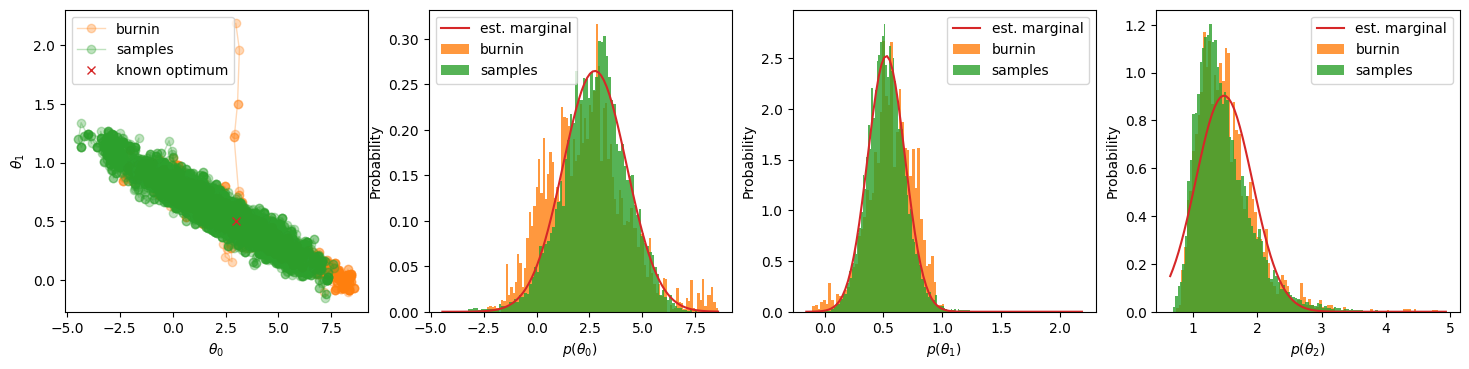

In [10]:
theta_map = np.ones(3)

fig = plt.figure(figsize=(18, 4), dpi=100)
ax = fig.subplots(1, 4)
ax[0].set_xlabel("$\\theta_0$")
ax[0].set_ylabel("$\\theta_1$")
ax[0].plot(samples[:n_burnin, 0], samples[:n_burnin, 1], 'o-', color='C1', linewidth=1, label="burnin", alpha=.3)
ax[0].plot(samples[n_burnin:, 0], samples[n_burnin:, 1], 'o-', color='C2', linewidth=1, label="samples", alpha=.3)
ax[0].plot(3, .5, 'x', color='C3', label="known optimum")
ax[0].legend()
#plt.axis('equal')
for i in range(3):
  ax[i+1].set_xlabel("$p(\\theta_%i)$" % i)
  ax[i+1].set_ylabel("Probability")
  ax[i+1].hist(samples[:n_burnin, i], 100, color='C1', alpha=.8, density=True, label="burnin")
  ax[i+1].hist(samples[n_burnin:, i], 100, color='C2', alpha=.8, density=True, label="samples")
  x_plot = np.linspace(samples[:, i].min(), samples[:, i].max(), 100)
  dist = norm(np.mean(samples[n_burnin:, i]), np.std(samples[n_burnin:, i]))
  theta_map[i] = dist.mean()
  ax[i+1].plot(x_plot, dist.pdf(x_plot), 'C3', label="est. marginal")
  ax[i+1].legend()
fig.show()
print("MAP estimate for theta is %s" % theta_map)

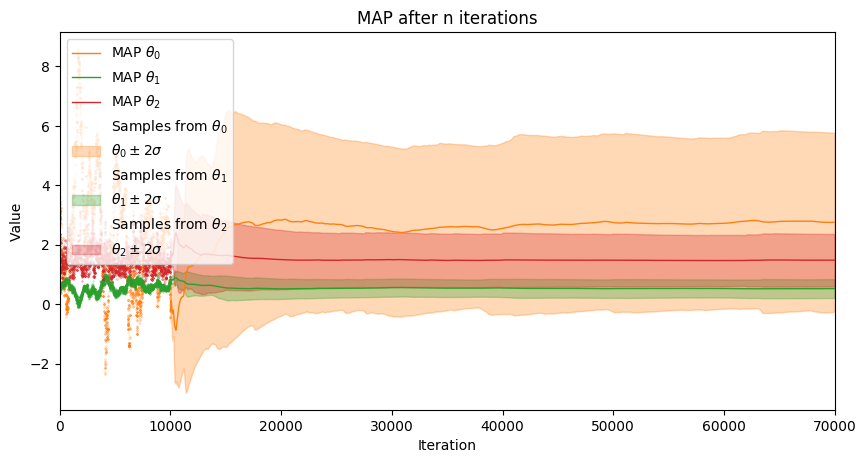

In [11]:
plt.figure(figsize=(10, 5), dpi=100)
x = np.arange(samples.shape[0])
for i in range(3):
  mu = np.asarray([np.mean(samples[n_burnin:n, i]) for n in range(n_burnin+1, samples.shape[0])])
  sigma = np.asarray([np.std(samples[n_burnin:n, i]) for n in range(n_burnin+1, samples.shape[0])])
  #plt.scatter(x[n_burnin:], samples[n_burnin:, i], c="C%i" % (i+1), s=1, alpha=.1, marker='x')
  plt.scatter(x[:n_burnin], samples[:n_burnin, i], c="C%i" % (i+1), s=1, alpha=.1, marker='x', label="Samples from $\\theta_%i$" % i)
  plt.plot(x[n_burnin+1:], mu, color="C%i" % (i+1), linewidth=1, label="MAP $\\theta_%i$" % i)
  plt.fill_between(x[n_burnin+1:], mu-2*sigma, mu+2*sigma, color="C%i" % (i+1), alpha=.3, label="$\\theta_%i \\pm 2 \\sigma$" % i)
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.title("MAP after n iterations")
a = list(plt.axis())
a[0] = 0
a[1] = n_samples+n_burnin
plt.axis(a)
plt.legend()
plt.show()
# print(a)

Given a distribution for the parameter vector, we can sample a set of trendlines.

[[ 2.27071586 -0.22639913 -0.09285794]
 [-0.22639913  0.02500374  0.00950293]
 [-0.09285794  0.00950293  0.19482082]]


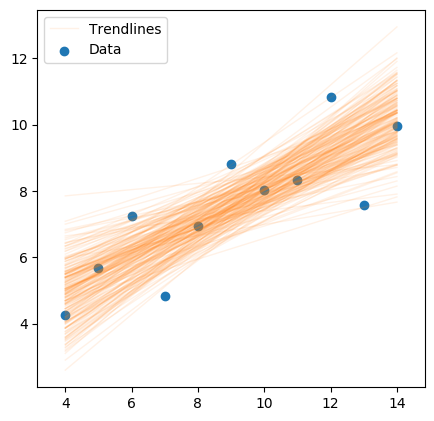

In [12]:
mu = np.mean(samples[n_burnin:, :], axis=0)
C = np.cov(samples[n_burnin:, :].T)
print(C)

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(X, y, color='C0', label="Data")
x_plot = np.linspace(X.min(), X.max(), 10)
for i in range(200):
  theta = np.random.multivariate_normal(mu, C)
  if i == 0:
    plt.plot(x_plot, y_hat(x_plot, theta), color='C1', linewidth=1, alpha=.1, label="Trendlines")
  else:
    plt.plot(x_plot, y_hat(x_plot, theta), color='C1', linewidth=1, alpha=.1)
plt.axis('equal')
plt.legend()
plt.show()